<a href="https://colab.research.google.com/github/MichaelTay/w281-summer-2023-project/blob/main/VGG19_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

mountdir = '/content/drive/'
drive.mount(mountdir, force_remount=True)

localdir = mountdir + 'MyDrive'
w281_dir = '/Berkeley/w281/Fruit-and-Vegetable-Classification/'
inputdir = localdir + w281_dir
vggdir = inputdir + 'modeling/vgg_data/'

Mounted at /content/drive/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os.path

from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_curve,
                             auc, RocCurveDisplay,
                             classification_report,
                             confusion_matrix,accuracy_score)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score, make_scorer, ConfusionMatrixDisplay
from sklearn.utils import shuffle

from hyperopt import tpe, atpe, rand, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
from hyperopt.early_stop import no_progress_loss

from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from tqdm import tqdm

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

data_dir = 'drive/MyDrive/Berkeley/w281/Fruit-and-Vegetable-Classification/modeling/pca_datasets/'

In [ ]:
!ls drive/MyDrive/Berkeley/w281/Fruit-and-Vegetable-Classification/modeling/pca_datasets/

test_daisy_lum_sat_hue.csv	validation_daisy_lum_sat_hue.csv
training_daisy_lum_sat_hue.csv


In [3]:
import os
import cv2

# Create a list with the filepaths for training and testing
train_dir = Path(inputdir, './input/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path(inputdir, './input/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path(inputdir, './input/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

## Filter only selected class

In [4]:
# Fruits - banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango.
# Vegetables - Bell Pepper, Cauliflower, Chilli Pepper, Peas, Corn, Spinach, Turnip, Garlic, Ginger, Cabbage
Fruits = ['banana', 'apple', 'pear', 'grapes', 'orange', 'kiwi', 'watermelon', 'pomegranate', 'pineapple', 'mango']
Vegetables = ['bell pepper', 'cauliflower', 'chilli pepper', 'peas', 'corn', 'spinach', 'turnip', 'garlic', 'ginger', 'cabbage']

train_df = train_df[train_df['Label'].isin(Fruits + Vegetables)]
test_df = test_df[test_df['Label'].isin(Fruits + Vegetables)]
val_df = val_df[val_df['Label'].isin(Fruits + Vegetables)]

print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 1540

Number of different labels: 20

Labels: ['pineapple' 'spinach' 'chilli pepper' 'corn' 'banana' 'turnip'
 'cauliflower' 'pomegranate' 'garlic' 'cabbage' 'peas' 'grapes' 'orange'
 'apple' 'mango' 'pear' 'ginger' 'watermelon' 'kiwi' 'bell pepper']


## Image processing

In [5]:
RANDOM_SEED = 1234
IMG_DIM = 512

def image_processing(path):

    img = imread(path)
    resized_img = resize(img, (IMG_DIM, IMG_DIM), anti_aliasing=True).astype(np.float32)
    resized_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2BGR)
    return resized_img

#### Processing Train images

In [6]:
train_images = []
train_labels = []

for i,j in enumerate(train_df.iterrows()):
    print(f"Processing image #: {i}")
    filepath, label = j[1]['Filepath'], j[1]['Label']

    try:
        im = image_processing(filepath)
        train_images.append(im)
        train_labels.append(label)
    except Exception as e:
        print(f"There was an {e.__class__.__name__} error while trying to process an image... continuing")
        print(f"The error occurred at image #{i}, {filepath}")
        continue

train_images = np.array(train_images)
train_labels = np.array(train_labels)

Processing image #: 0
Processing image #: 1
Processing image #: 2
Processing image #: 3
Processing image #: 4
Processing image #: 5
Processing image #: 6
Processing image #: 7
Processing image #: 8
Processing image #: 9
Processing image #: 10
Processing image #: 11
Processing image #: 12
Processing image #: 13
Processing image #: 14
Processing image #: 15
Processing image #: 16
Processing image #: 17
Processing image #: 18
Processing image #: 19
Processing image #: 20
Processing image #: 21
Processing image #: 22
Processing image #: 23
Processing image #: 24
Processing image #: 25
Processing image #: 26
Processing image #: 27
Processing image #: 28
Processing image #: 29
Processing image #: 30
Processing image #: 31
Processing image #: 32
Processing image #: 33
Processing image #: 34
Processing image #: 35
Processing image #: 36
Processing image #: 37
Processing image #: 38
Processing image #: 39
Processing image #: 40
Processing image #: 41
Processing image #: 42
Processing image #: 4

#### Processing Validation images

In [7]:
validation_images = []
validation_labels = []

for i,j in enumerate(val_df.iterrows()):
    print(f"Processing image #: {i}")
    filepath, label = j[1]['Filepath'], j[1]['Label']

    try:
        im = image_processing(filepath)
        validation_images.append(im)
        validation_labels.append(label)
    except Exception as e:
        print(f"There was an {e.__class__.__name__} error while trying to process an image... continuing")
        print(f"The error occurred at image #{i}, {filepath}")
        continue

validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

Processing image #: 0
Processing image #: 1
Processing image #: 2
Processing image #: 3
Processing image #: 4
Processing image #: 5
Processing image #: 6
Processing image #: 7
Processing image #: 8
Processing image #: 9
Processing image #: 10
Processing image #: 11
Processing image #: 12
Processing image #: 13
Processing image #: 14
Processing image #: 15
Processing image #: 16
Processing image #: 17
Processing image #: 18
Processing image #: 19
Processing image #: 20
Processing image #: 21
Processing image #: 22
Processing image #: 23
Processing image #: 24
Processing image #: 25
Processing image #: 26
Processing image #: 27
Processing image #: 28
Processing image #: 29
Processing image #: 30
Processing image #: 31
Processing image #: 32
Processing image #: 33
Processing image #: 34
Processing image #: 35
Processing image #: 36
Processing image #: 37
Processing image #: 38
Processing image #: 39
Processing image #: 40
Processing image #: 41
Processing image #: 42
Processing image #: 4

#### Processing Test images

In [8]:
test_images = []
test_labels = []

for i,j in enumerate(test_df.iterrows()):
    print(f"Processing image #: {i}")
    filepath, label = j[1]['Filepath'], j[1]['Label']

    try:
        im = image_processing(filepath)
        test_images.append(im)
        test_labels.append(label)
    except Exception as e:
        print(f"There was an {e.__class__.__name__} error while trying to process an image... continuing")
        print(f"The error occurred at image #{i}, {filepath}")
        continue

test_images = np.array(test_images)
test_labels = np.array(test_labels)

Processing image #: 0
Processing image #: 1
Processing image #: 2
Processing image #: 3
Processing image #: 4
Processing image #: 5
Processing image #: 6
Processing image #: 7
Processing image #: 8
Processing image #: 9
Processing image #: 10
Processing image #: 11
Processing image #: 12
Processing image #: 13
Processing image #: 14
Processing image #: 15
Processing image #: 16
Processing image #: 17
Processing image #: 18
Processing image #: 19
Processing image #: 20
Processing image #: 21
Processing image #: 22
Processing image #: 23
Processing image #: 24
Processing image #: 25
Processing image #: 26
Processing image #: 27
Processing image #: 28
Processing image #: 29
Processing image #: 30
Processing image #: 31
Processing image #: 32
Processing image #: 33
Processing image #: 34
Processing image #: 35
Processing image #: 36
Processing image #: 37
Processing image #: 38
Processing image #: 39
Processing image #: 40
Processing image #: 41
Processing image #: 42
Processing image #: 4

In [9]:
train_label_encoder = LabelEncoder()
encoded_train_labels = train_label_encoder.fit_transform(train_labels)

validation_label_encoder = LabelEncoder()
encoded_validation_labels = validation_label_encoder.fit_transform(validation_labels)

test_label_encoder = LabelEncoder()
encoded_test_labels = test_label_encoder.fit_transform(test_labels)

## VGG model

In [10]:
VGG_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_DIM, IMG_DIM, 3))

for layer in VGG_model.layers:
    layer.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [11]:
VGG_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

## Modeling

##### Features: <br> VGG-19

##### Make VGG-19 training feature

In [12]:
extracted_train_features = VGG_model.predict(train_images)

49/49 [==============================] - 2937s 60s/step


In [13]:
X_train = extracted_train_features.reshape(extracted_train_features.shape[0], -1)

In [14]:
encoded_train_labels.shape

(1540,)

##### Make VGG-19 validation feature

In [15]:
extracted_validation_feature = VGG_model.predict(validation_images)

6/6 [==============================] - 356s 59s/step


In [16]:
X_val = extracted_validation_feature.reshape(extracted_validation_feature.shape[0], -1)

#### Make VGG-19 test feature

In [17]:
extracted_test_feature = VGG_model.predict(test_images)

6/6 [==============================] - 354s 58s/step


In [18]:
X_test = extracted_test_feature.reshape(extracted_test_feature.shape[0], -1)

### PCA

In [19]:
# Import required modules
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:


def plotPCA(df, n_components=200):

  # Perform fit
  pca = PCA(n_components=n_components)
  pca_result = pca.fit_transform(df)

  PC_values = np.arange(pca.n_components_) + 1
  plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
  plt.bar(PC_values, np.cumsum(pca.explained_variance_ratio_), color ='maroon',
          width = 0.4)
  plt.ylim(0.0,1.05)

  plt.xlabel('Principal Component')
  plt.ylabel('Variance Explained')
  plt.show()

In [20]:
scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(X_train)
scaled_x_val = scaler.transform(X_val)

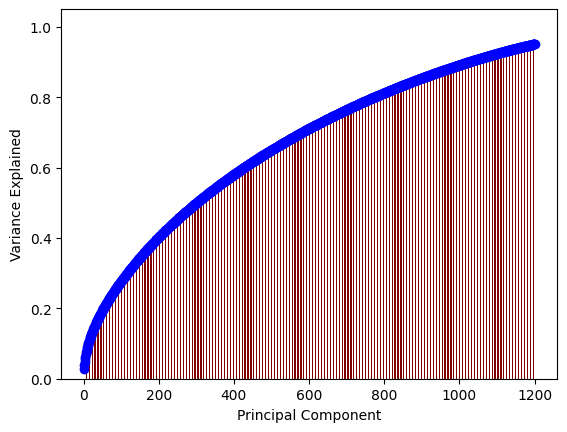

In [ ]:
plotPCA(scaled_x_train, 1200)

In [21]:
pca = PCA(n_components=1200)
pca_x_train = pca.fit_transform(X_train)
pca_x_val = pca.transform(X_val)
pca_x_test = pca.transform(X_test)

In [ ]:
# pd.concat([pd.DataFrame(pca_x_train),pd.DataFrame(encoded_train_labels)], axis=1).to_csv(vggdir+'vgg_train.csv')
# pd.concat([pd.DataFrame(pca_x_val),pd.DataFrame(encoded_validation_labels)], axis=1).to_csv(vggdir+'vgg_validation.csv')
# pd.concat([pd.DataFrame(pca_x_test),pd.DataFrame(encoded_test_labels)], axis=1).to_csv(vggdir+'vgg_test.csv')


##### Bayesian Parameter Search

In [36]:
# space = {'eta': hp.uniform('eta',0.001, 0.1),
#         "n_estimators":hp.choice("n_estimators",list(np.arange(100, 1000,200,dtype=int))),
#         "max_depth": hp.choice("max_depth", list(np.arange(1, 15,1,dtype=int))),
#         "subsample": hp.uniform('subsample', 0.3, 0.8),
#          "colsample_bytree": hp.uniform('colsample_bytree', 0.3, 0.8),
#          "gamma": hp.uniform('gamma', 0.0, 0.9),
#          "min_child_weight": hp.choice('min_child_weight', np.arange(1,8,2, dtype=int)),
#          "reg_alpha": hp.uniform("reg_alpha", 0.001, 1)
#         }

space = {'eta': hp.uniform('eta',0.00001, 1),
        # "n_estimators" : hp.choice("n_estimators", list(np.arange(100, 500, 100))),
        # "subsample": hp.uniform('subsample', 0.3, 0.8),
        #  "colsample_bytree": hp.uniform('colsample_bytree', 0.3, 0.8),
        #  "gamma": hp.uniform('gamma', 0.0, 0.9),
        #  "min_child_weight": hp.choice('min_child_weight', np.arange(1,8,2, dtype=int)),
        #  "reg_alpha": hp.uniform("reg_alpha", 0.001, 1)
        }

In [37]:
def optimize_xg(params):

    skf = StratifiedKFold(n_splits=2)
    clf = xgb.XGBClassifier(**params)
    cv_accuracy = cross_val_score(clf, pca_x_train, encoded_train_labels,
                         scoring=make_scorer(accuracy_score),
                                cv=skf,
                                n_jobs=-1).mean()
    best_score = np.mean(cv_accuracy)
    loss = 1 - best_score
    return {"loss":loss, "status":STATUS_OK}


In [38]:
trials = Trials()

best = fmin(
    fn=optimize_xg,
    space=space,
    algo=rand.suggest,
    # algo=atpe.suggest,
    # algo=tpe.suggest,
    max_evals=3,
    trials=trials,
    early_stop_fn=no_progress_loss(5),
    rstate=np.random.default_rng(RANDOM_SEED)
)

print("Best: {}".format(best))

100%|██████████| 3/3 [03:48<00:00, 76.05s/trial, best loss: 0.5480519480519481]
Best: {'eta': 0.2104541523275835}


#### XGBoost with Hyperopt params on Validation set

In [39]:
params = {'eta':0.2104541523275835,
          'n_estimators': 300}

[0]	validation_0-mlogloss:2.13173	validation_1-mlogloss:1.96121
[1]	validation_0-mlogloss:1.62705	validation_1-mlogloss:1.44466
[2]	validation_0-mlogloss:1.27832	validation_1-mlogloss:1.12454
[3]	validation_0-mlogloss:1.02744	validation_1-mlogloss:0.90059
[4]	validation_0-mlogloss:0.83835	validation_1-mlogloss:0.73813
[5]	validation_0-mlogloss:0.68902	validation_1-mlogloss:0.60909
[6]	validation_0-mlogloss:0.57170	validation_1-mlogloss:0.51201
[7]	validation_0-mlogloss:0.47877	validation_1-mlogloss:0.43501
[8]	validation_0-mlogloss:0.40268	validation_1-mlogloss:0.37407
[9]	validation_0-mlogloss:0.34033	validation_1-mlogloss:0.32744
[10]	validation_0-mlogloss:0.28853	validation_1-mlogloss:0.28751
[11]	validation_0-mlogloss:0.24609	validation_1-mlogloss:0.25609
[12]	validation_0-mlogloss:0.21096	validation_1-mlogloss:0.23028
[13]	validation_0-mlogloss:0.18183	validation_1-mlogloss:0.20807
[14]	validation_0-mlogloss:0.15733	validation_1-mlogloss:0.19068
[15]	validation_0-mlogloss:0.13708	

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

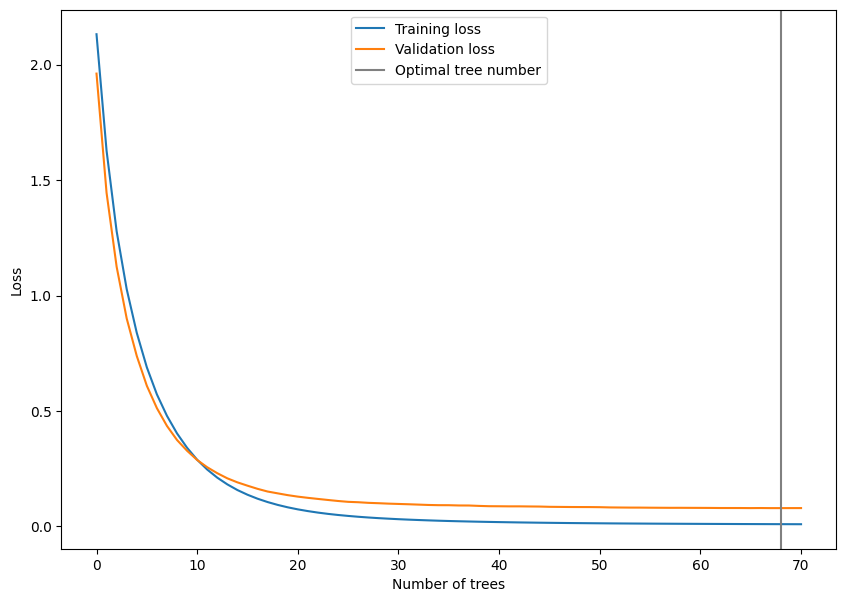

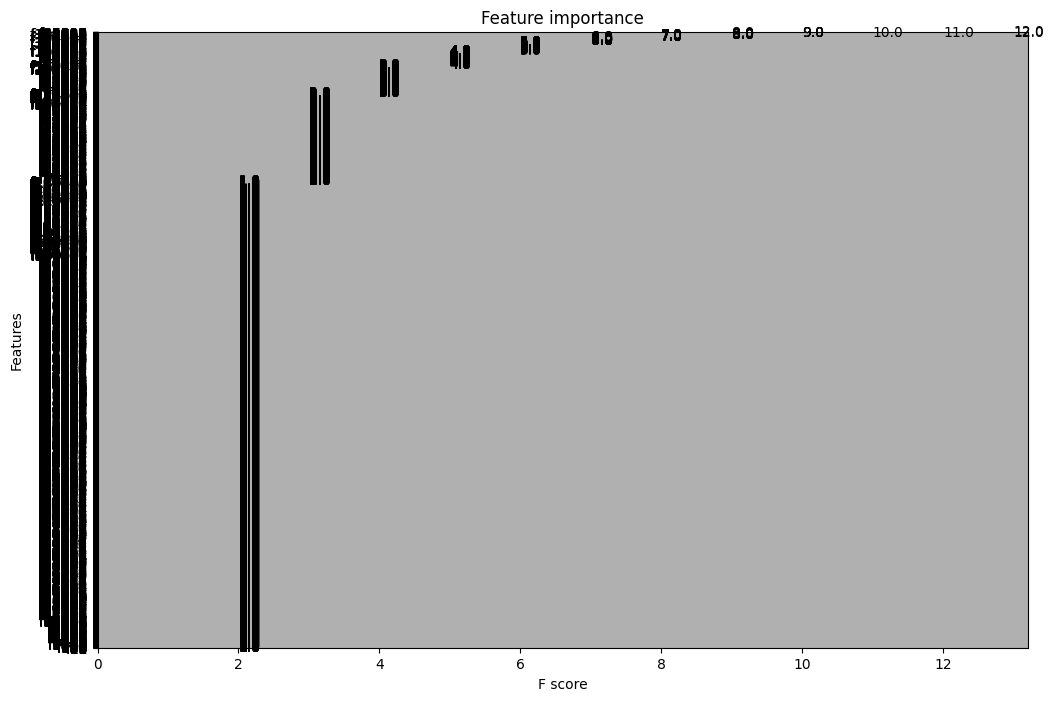

In [40]:

## use the wherevery XGboost early stops as n_estimator parameter in final model
xg1 = xgb.XGBClassifier(**params,
                        early_stopping_rounds=3,
                        n_jobs=-1)

xg1.fit(X_train, encoded_train_labels,
            eval_set=[(X_train, encoded_train_labels), (X_val, encoded_validation_labels)])

val_results = xg1.evals_result()
plt.figure(figsize=(10,7))
plt.plot(val_results["validation_0"]["mlogloss"], label="Training loss")
plt.plot(val_results["validation_1"]["mlogloss"], label="Validation loss")
plt.axvline(xg1.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(xg1,ax=ax)

In [41]:
xg1.best_ntree_limit

68

#### Inference on Validation Set

In [42]:
xg_val_clf = xgb.XGBClassifier(n_estimators=68,
                               eta=0.2104541523275835,
                               n_jobs=-1)

xg_val_clf.fit(pca_x_train, encoded_train_labels)

y_pred = xg_val_clf.predict(pca_x_val)

print(accuracy_score(encoded_validation_labels, y_pred))

0.9786096256684492


In [43]:
print(classification_report(encoded_validation_labels
                            ,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.88      0.78      0.82         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        10
           7       0.91      1.00      0.95        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00         7
          13       1.00      1.00      1.00        10
          14       0.90      1.00      0.95         9
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00        10
          17       1.00    

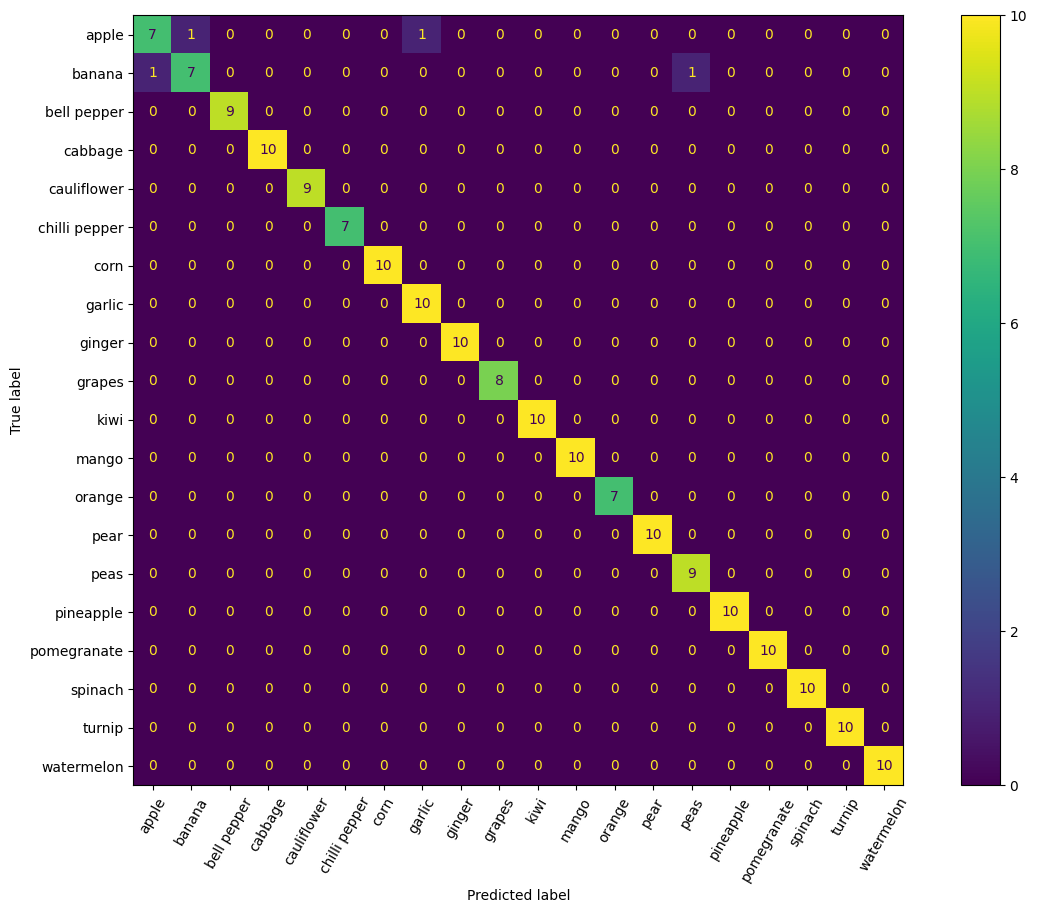

In [45]:
inverse_val_labels = validation_label_encoder.inverse_transform(encoded_validation_labels)
inverse_y_pred = validation_label_encoder.inverse_transform(y_pred)

fig, ax = plt.subplots(figsize=(15,10))
ConfusionMatrixDisplay.from_predictions(inverse_val_labels, inverse_y_pred, xticks_rotation=60, ax=ax);

#### Inference on Test Set

In [46]:
xg_test_clf = xgb.XGBClassifier(n_estimators=68,
                               eta=0.2104541523275835,
                               n_jobs=-1)

xg_test_clf.fit(pca_x_train, encoded_train_labels)

y_pred_test = xg_test_clf.predict(pca_x_test)

print(accuracy_score(encoded_test_labels, y_pred_test))

0.9786096256684492


In [51]:
y_proba = xg_test_clf.predict_proba(pca_x_test)

In [48]:
inverse_test_labels = test_label_encoder.inverse_transform(encoded_test_labels)
inverse_y_test_pred = test_label_encoder.inverse_transform(y_pred_test)

In [49]:
print(classification_report(inverse_test_labels,
                            inverse_y_test_pred))

               precision    recall  f1-score   support

        apple       0.88      0.78      0.82         9
       banana       0.88      0.78      0.82         9
  bell pepper       1.00      1.00      1.00         9
      cabbage       1.00      1.00      1.00        10
  cauliflower       1.00      1.00      1.00         9
chilli pepper       1.00      1.00      1.00         7
         corn       1.00      1.00      1.00        10
       garlic       0.91      1.00      0.95        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         8
         kiwi       1.00      1.00      1.00        10
        mango       1.00      1.00      1.00        10
       orange       1.00      1.00      1.00         7
         pear       1.00      1.00      1.00        10
         peas       0.90      1.00      0.95         9
    pineapple       1.00      1.00      1.00        10
  pomegranate       1.00      1.00      1.00        10
      spi

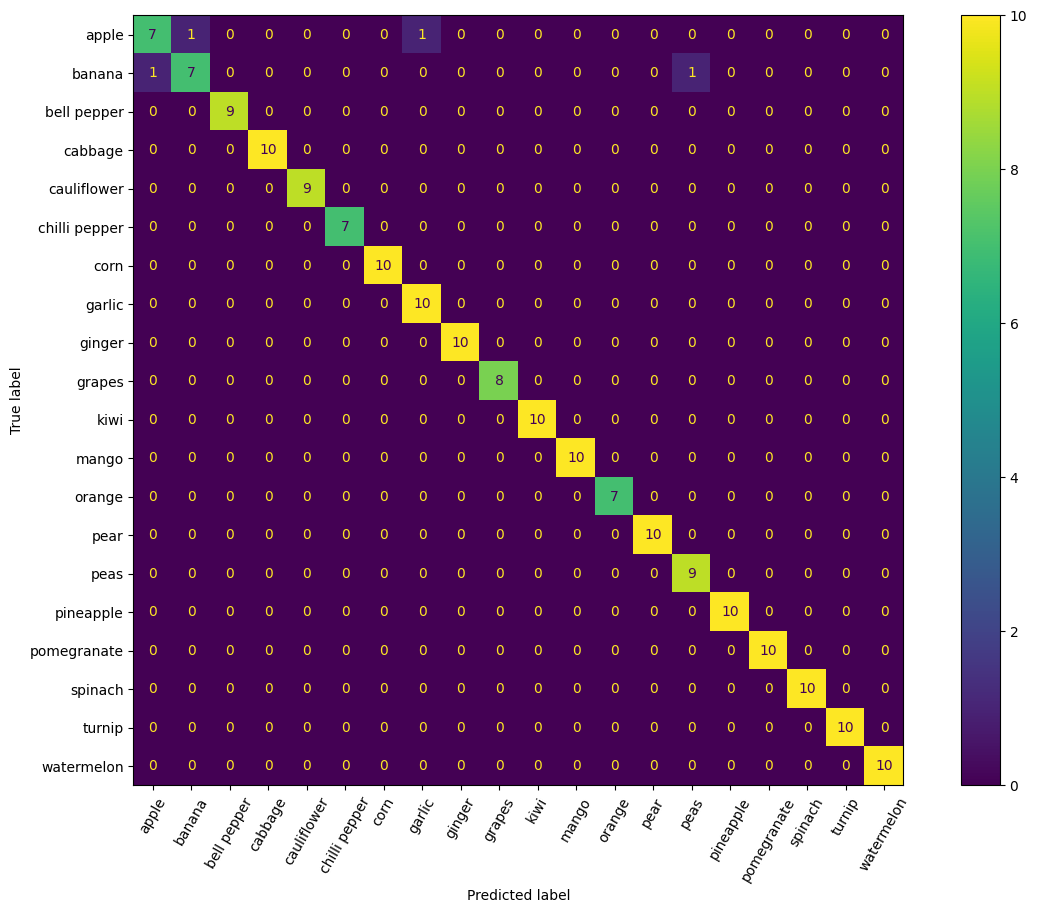

In [50]:
fig, ax = plt.subplots(figsize=(15,10))
ConfusionMatrixDisplay.from_predictions(inverse_test_labels, inverse_y_test_pred, xticks_rotation=60, ax=ax);

## Test set ROC curve

In [54]:
unique_training_labels = set([i for i in encoded_train_labels.tolist()])
unique_val_labels = set([i for i in encoded_validation_labels.tolist()])
unique_test_labels = set([i for i in encoded_test_labels.tolist()])

all_unique_labels = set(list(unique_training_labels) + list(unique_val_labels) + list(unique_test_labels))
all_unique_labels = sorted(list(all_unique_labels))
label_numeric_mapping = {k:v for v,k in enumerate(all_unique_labels)}

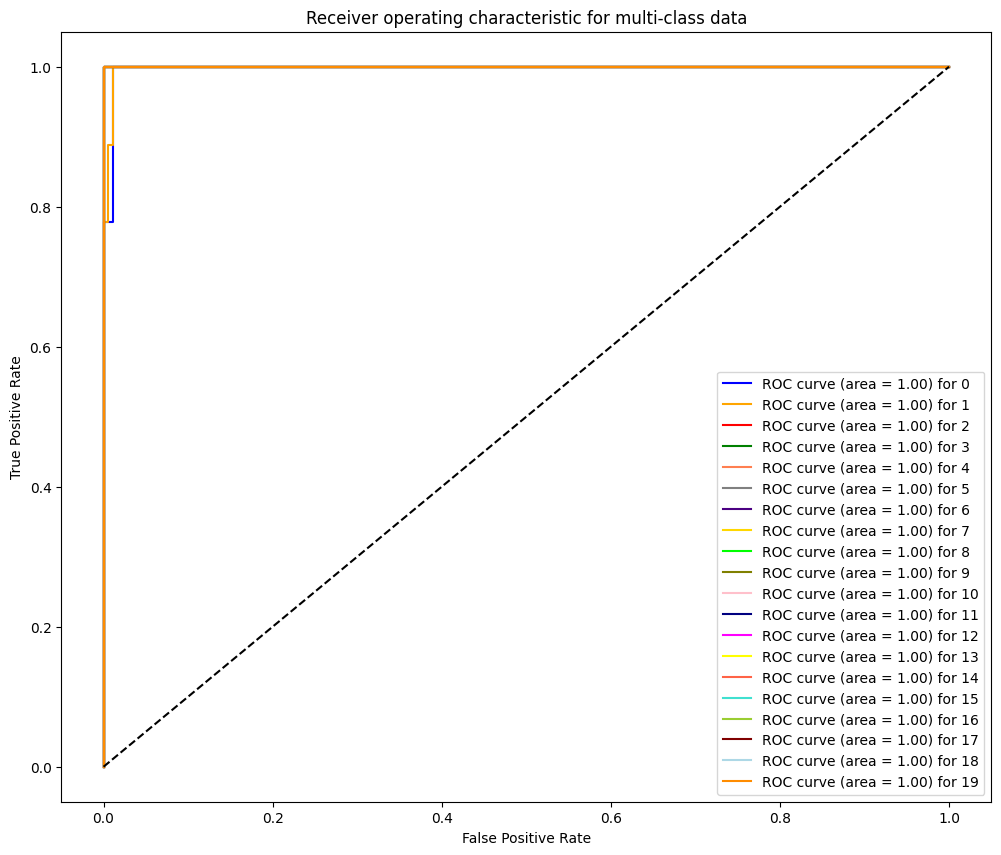

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

fig, ax = plt.subplots(figsize=(12,10))

color = ['blue', 'orange', 'red', 'green', 'coral',
          'grey', 'indigo', 'gold', 'lime', 'olive',
          'pink', 'navy', 'magenta', 'yellow', 'tomato',
          'turquoise', 'yellowgreen', 'maroon', 'lightblue', 'darkorange']

for class_id in range(0, len(all_unique_labels)):
    label_binarizer = LabelBinarizer().fit(encoded_train_labels)
    y_onehot_test = label_binarizer.transform(encoded_test_labels)
    fpr, tpr, _ = roc_curve(y_onehot_test[:,class_id], y_proba[:,class_id])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color[class_id], label='ROC curve (area = %0.2f) for %s' % (roc_auc, all_unique_labels[class_id]))

plt.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic for SVM Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()